In [1]:
%matplotlib inline

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.cla import CLA

# Portfolio optimization vs pure index fund investing during COVID-19 crisis

### Would an investor have been better prepared for the market volatility in 2020 if he was following the principles of Modern Portfolio Theory than just being invested in the market index?

#### In this real-world experiment we look at the relative performance and risk indicators of three investment portfolios during the first five months of 2020 – a period, characterized by some of the most extreme market movements in stock market history, both up and down. Our aim is to gain some insight into whether the most-famous portfolio management theory - the one of the Nobel laurate Harry Markowitz, Modern Portfolio Theory (MPT) – can still serve investors well during such highly turbulent times. 

Our investment universe is the oldest US stock market index – Dow Jones Industrial Average 30. Looking at the experiment from the perspective of an individual investor interested in gaining exposure to this index for his investment goals in 2020, we review the following alternatives for him: 

1)	hassle-free investment in the biggest ETF that resembles the performance of Dow Jones 30 - SPDR Dow Jones Industrial Average ETF (DIA)

2)	an optimized Maximum Sharpe Ratio portfolio (MSR) – the one with the highest Sharpe ratio (i.e. risk-adjusted return) on the Efficient Frontier

3)	an optimized Global Minimum Volatility portfolio (GMV) – the one with the lowest level of risk on the Efficient Frontier

The Efficient Frontier Optimisation is based on Harry Markowitz’s 1952 classic paper [1], which turned portfolio management from an art into a science. The key insight is that by combining assets with different expected returns and volatilities, one can decide on a mathematically optimal allocation. Any portfolio lying on the Efficient Frontier is considered to be “optimal” in terms of risk vs return – allowing investors to choose any of them depending on their risk tolerance and/or return target.

<div>
<img src="https://i.ibb.co/KGxyS4W/EF.jpg" width = "400"/>
</div>

To achieve our goal, we need to go through the following steps:

1. Gathering historical market data about all components of DJIA 30 until 31-12-2019- we think that two years of historical daily prices give us an excellent insight about stocks` risk and return characteristics given the elevated market volatility during this generally positive stock market period


2. Deriving the inputs - return and volatility - needed to build the Efficient Frontier from these 30 stocks


3. Building the Efficient Frontier and then finding the stocks weights at its two most interesting points – the MSR and GMV portfolios


4. Gathering historical market data about our stock universe in the first five months of 2020, pplying it to our three model portfolios and visualizing the results


5. Evaluating the performance using risk management analysis

As we understand that just one experiment is very insufficient to draw more general conclusions about the debate of MPT vs pure index investing, we end this exercise with a list of possible further steps towards more comprehensive understanding of the topic. 

### 1. Gathering Data

To gather historical data, we will use yfinance, an excellent library that provides free price data from Yahoo Finance, no API key needed.

In [3]:
DJ30_tickers = ["MMM", "AXP", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DD", "XOM", "GS", "HD", "IBM", "INTC", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "PFE", "PG", "RTX", "TRV", "UNH", "VZ", "V", "WMT", "WBA", "DIS"]
# we auto adjust our data for any corporate actions (dividends, splits) that may artificially affect the price fluctuations
stocks_data = yf.download(DJ30_tickers, start='2017-12-29', end='2019-12-31', auto_adjust = True)

[*********************100%***********************]  30 of 30 completed


In [4]:
# we will work with the Closing daily price only
stocks_prices = stocks_data["Close"]
stocks_prices

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-29,163.133469,95.173958,281.047150,146.389938,35.270294,111.234879,92.007080,104.554008,243.205765,178.164459,...,32.728546,84.711304,74.760979,127.835030,212.073120,112.023186,46.942368,66.625313,93.333244,72.685234
2018-01-02,166.054321,94.819359,282.886383,145.888275,35.786003,113.358467,92.885559,108.726067,244.074509,176.754425,...,32.927341,83.577293,75.106758,124.385643,212.746506,112.504623,47.474491,68.762985,93.182022,73.893188
2018-01-03,166.025375,95.403954,283.801239,146.111237,36.071476,114.184792,94.371216,109.192856,241.802444,177.675644,...,33.171303,83.475838,76.208481,124.781448,214.978226,113.624641,46.498932,69.276764,93.994858,75.344444
2018-01-04,166.796555,96.990829,282.724396,148.117828,36.173531,113.829384,96.179825,109.144241,245.181931,179.085724,...,33.243599,84.065926,76.448776,124.781448,215.911316,114.047112,46.649700,65.689522,94.079918,75.448730
2018-01-05,168.695572,97.212029,294.322296,150.458908,36.674522,113.642799,97.432945,108.551003,243.931305,180.956360,...,33.306850,84.121231,77.105133,124.555283,220.028488,116.778435,46.543266,66.900566,94.637550,75.387894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,282.054138,122.817421,335.553558,145.037827,46.930817,115.553078,62.787884,144.679993,226.283295,216.460632,...,38.165321,122.566338,92.069183,134.436462,292.557281,186.215652,59.453365,56.759140,117.503563,66.662033
2019-12-24,282.322266,123.064056,331.030457,144.041626,46.618591,115.562683,62.650368,145.289993,227.093277,217.902313,...,38.136204,122.880356,91.915550,134.041733,292.011993,186.703415,59.337166,56.545940,117.977409,66.405968
2019-12-26,287.923645,123.725060,327.968689,144.764374,46.686893,115.812355,62.601254,145.699997,228.377335,218.050446,...,38.223560,122.880356,92.616127,134.495667,293.112457,188.286041,59.346851,57.078938,117.987274,66.510292


In [5]:
# checking for missing values
stocks_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2017-12-29 to 2019-12-30
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    503 non-null    float64
 1   AXP     503 non-null    float64
 2   BA      503 non-null    float64
 3   CAT     503 non-null    float64
 4   CSCO    503 non-null    float64
 5   CVX     503 non-null    float64
 6   DD      503 non-null    float64
 7   DIS     503 non-null    float64
 8   GS      503 non-null    float64
 9   HD      503 non-null    float64
 10  IBM     503 non-null    float64
 11  INTC    503 non-null    float64
 12  JNJ     503 non-null    float64
 13  JPM     503 non-null    float64
 14  KO      503 non-null    float64
 15  MCD     503 non-null    float64
 16  MMM     503 non-null    float64
 17  MRK     503 non-null    float64
 18  MSFT    503 non-null    float64
 19  NKE     503 non-null    float64
 20  PFE     503 non-null    float64
 21  PG      503 non-null

### 2. Calculating the expected return and covariance matrix

We will use simple estimates like the mean of past returns and sample covariance matrix to provide our inputs for optimization. More sophisticated methods for deriving these inputs are discussed in the end of the notebook as possible future extensions of it.

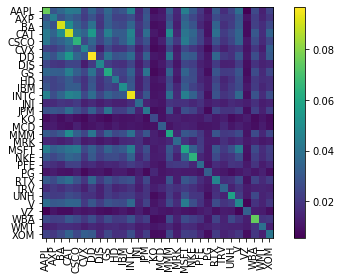

In [6]:
# getting the historical returns and removing the first row which cannot be calculated
stocks_returns = stocks_prices.pct_change().iloc[1:,]

# calculating the annualized mean and covariance matrix of our universe
stocks_returns_annualized = ((1+stocks_returns.mean())**252)-1
cov_matrix_annualized = stocks_returns.cov()*252

# examining our covariance matrix -> brighter spots outside the diagonal indicate more extreme values among the stocks (co-movements)
plotting.plot_covariance(cov_matrix_annualized)

### 3. Constructing the efficient frontier and finding our optimum portfolios

We will use PyPortfolioOpt library in Python [2] as a very usefull ready-made tool for portfolio optimizations. It provides us with the standard Efficient Frontier Optimisation as well as alternative optimizers like the Markowitz` Critial Line Algorithm (CLA). In our case, we are interested in long-only portfolios and this constraint (stock weight between 0 and 1) is limiting the functionality of the standard EF model based on generic quadratic optimisers. This problem is resolved when using CLA which is specially designed for portfolio optimisation and guarantees that the exact solution is found after a given number of iterations [3]. It is also the method that allows us to visualise the efficient frontier in PyPortfolioOpt.

No handles with labels found to put in legend.


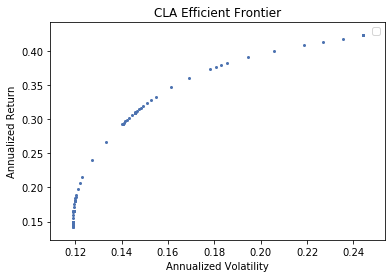

In [7]:
cla = CLA(stocks_returns_annualized, cov_matrix_annualized)

# plotting our EF of DJIA30 stocks
(ret, vol, weights) = cla.efficient_frontier()
plt.scatter (vol, ret, s= 4)
plt.title ("CLA Efficient Frontier")
plt.xlabel ("Annualized Volatility")
plt.ylabel ("Annualized Return")
plt.legend()
plt.show()

In [8]:
# an attempt to find the MSR and GMV using the standard EF optimisation model
#ef = EfficientFrontier(stocks_returns_annualized, cov_matrix_annualized)
#ef.max_sharpe()
#ef.min_volatility() # works only if ef = EfficientFrontier(weight_bounds=(-1, 1))

In [9]:
# we will use the maximum sharpe ratio and minimum volatility portfolios derived from CLA optimization
max_sharpe = cla.max_sharpe()
min_var = cla.min_volatility()

# we need to convert the values of these porfolios (i.e. stock weights) from OrderedDict to list in order to use them further 
MSR_weights = list(max_sharpe.values())
GMV_weights = list(min_var.values())

### 4. Model portfolios performance during COVID-19 crisis

We will use once again yfinance to download our data - this time for the period of our experiment, January to May 2020. As a publicly traded ETF, DIA portfolio performance is directly available. For MSR and GMV portfolios we need to apply the newly-acquired weights to the DJIA 30 stocks. We will then visualise the relative performance and returns distributions of our porfolios to get acquainted with their performance during the COVID-19 crisis. 

In [10]:
stocks_data_2020 = yf.download(DJ30_tickers, start='2019-12-31', end='2020-05-31', auto_adjust = True)
DIA_data_2020 = yf.download("DIA", start='2019-12-31', end='2020-05-31', auto_adjust = True)

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
# converting stock data to daily returns and removing the first row
stocks_returns_2020 = stocks_data_2020["Close"].pct_change().iloc[1:,]
DIA_returns_2020 = DIA_data_2020["Close"].pct_change().iloc[1:,]

# calculating the daily returns of our model portfolios using the optimized weights
MSR_returns_2020 = stocks_returns_2020.dot(MSR_weights)
GMV_returns_2020 = stocks_returns_2020.dot(GMV_weights)

In [12]:
# merging the three pandas series into one pandas DataFrame and renaming the columns
portfolios_2020 = pd.concat([DIA_returns_2020, GMV_returns_2020, MSR_returns_2020], join="inner", axis=1)
portfolios_2020.columns = ["DIA", "GMV", "MSR"]

Text(0.5, 1.0, 'Model portfolios - Cumulative returns in 2020')

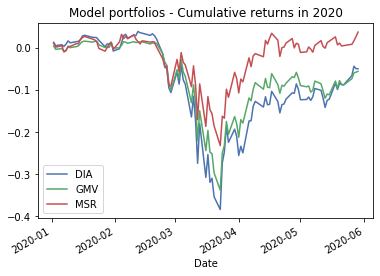

In [13]:
# plotting our newly created DataFrame with cumulative returns of the portfolios
portfolios_2020.cumsum().plot()
plt.title ("Model portfolios - Cumulative returns in 2020")

Text(0.5, 1.0, 'Model portfolios - Daily returns distributions in 2020')

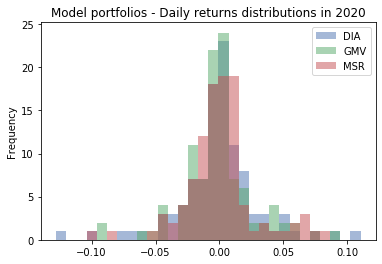

In [14]:
# visualising the distributions of returns - histograms
portfolios_2020.plot.hist(alpha=0.5, bins = 30)
plt.title ("Model portfolios - Daily returns distributions in 2020")

Text(0.5, 1.0, 'Model portfolios - Daily returns distributions in 2020')

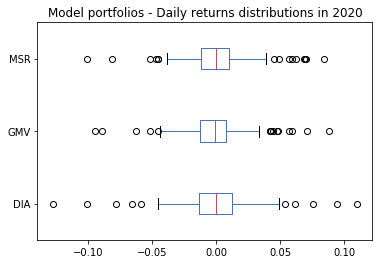

In [15]:
# visualising the distributions of returns - boxplots
portfolios_2020.plot.box(vert=False)
plt.title ("Model portfolios - Daily returns distributions in 2020")

In [16]:
# statistical summary of our distributions of returns
statistical_moments = round(portfolios_2020.agg(["min", "max", "mean", "std", "skew", "kurt"]),3)
statistical_moments

,DIA,GMV,MSR
min,-0.128,-0.094,-0.101
max,0.110,0.088,0.084
mean,-0.000,-0.001,0.000
std,0.033,0.028,0.028
skew,-0.255,-0.085,0.117
kurt,3.754,2.601,2.695


As of this moment, it already becomes quite clear that the MSR portfolio is the best performing portfolio during the covid-19 crisis – we can see from the first graph that it had much lower drawdown in March (i.e. best tail-risk protection) and then recovered rapidly (so also strong return potential), thus closing the first five months of the year with significant return outperformance vs GMV and DIA.

From the histogram, the box plot and the statistical summary we can also get the idea that DIA had the worst risk profile of the three, with the widest dispersion of returns (highest st.dev, the largest negative outliers) – which did not result in an overall return outperformance for the period, even compared to GMV. In other words, it didn’t compensate its investors for the higher risk taken compared to GMV and MSR – and avoiding such sub-optimal risk/return (or mean/variance) portfolios is exactly the idea of MPT.

The third and the fourth statistical moments are also providing us with some interesting information about the relative performance of our model portfolios - while the skewness of all three of them is modest and indicate approximately symmetric distribution (between 0.5 and -0.5), it is most negative for DIA (associated with fatter left tails, i.e. negative returns). Also, DIA is the only porfolio with kurtosis well-above the standard 3.0 (lepokurtic, indicating for longer and fatter tails) while MSR is the only one with a positive skew and similar to GMV kurtosis of well-below 3.0.

### 5. Performance evaluation using risk management analysis

We will now proceed with more in-depth analysis of the portfolios in order to gain even better perspective about their relative performance and behaviour during the turmoil. Our job here will also serve us very well in any future extensions of this experiment. 

We will focus our attention on the risk-adjusted returns of the portfolios (Sharpe and Sortino ratios) and their exposure to tail-risk scenarios (maximum drawdown and different measures of VaR).  

In [17]:
# defining a function with our risk management ratios that can be applied to any portoflio returns 
def risk_statistics (portfolio):
    
    # Share ratio is the most widely used indicator for risk-adjusted portfolio returns
    returns_annualized = ((1+portfolio.mean())**252)-1
    # we set up the risk free rate at 0.01 given the record plunge in yields last months 
    risk_free_rate = 0.01  
    vol_annualized = portfolio.std()*np.sqrt(252)
    sharpe_ratio = (returns_annualized - risk_free_rate) / vol_annualized
    if sharpe_ratio <0:
        sharpe_ratio = 0
    
    # Sortino ratio is very similar to Sharpe but focuses on the downside deviation only (below a target return, usually 0)
    target_return = 0
    negative_returns = portfolio.loc[portfolio < target_return].dropna()
    vol_downside_annualized = negative_returns.std()*np.sqrt(252)
    sortino_ratio = (returns_annualized - risk_free_rate) / vol_downside_annualized
    if sortino_ratio <0:
        sortino_ratio = 0
        
    # Maximum drawdown is giving us the percentage loss from the highest cumulative historical point
    cumulative_ret_portfolio =  ((1+portfolio).cumprod()-1)
    running_max = np.maximum.accumulate(cumulative_ret_portfolio)
    drawdown = cumulative_ret_portfolio - running_max     
    max_drawdown = drawdown.min()
        
    # We can use this max drawdown caclulation to derive the Calmar ratio - which compares return vs max drawdown
    calmar_ratio = returns_annualized / abs(max_drawdown)
    if calmar_ratio <0:
        calmar_ratio = 0
    
    # Value-at-risk at 95% confidence interval is the standard measure for tail-risk exposure
    # It gives us the maximum expected loss within the confidence interval (so 95% of the time)
    # The simplest method used is based on historical prices (assuming history will repeat itself)
    var_level = 95
    var_95 = np.percentile (portfolio, 100 - var_level)
    # Conditional VaR (or Expected Shortfall) is very useful addition to VaR 
    # It gives us an idea about the average loss outside the VaR confidence interval (so in the remaining 5% of the time)
    cvar_95 = portfolio[portfolio <= var_95].mean()
    
    # Another method for calculating VaR is the parametric one (or variance-covariance)
    # It takes the estimated return and st.dev of the portfolio and assumes the future returns will be normally distributed 
    mu = portfolio.mean()
    sigma = portfolio.std()
    par_var95 = norm.ppf (1-var_level/100, mu, sigma)
    
    # The third major method for estimating VaR is based on Monte Carlo simulations 
    # It takes the estimated return and st.dev of the portfolio and assumes the future returns will be randomly distributed 
    T = 252
    simulated_returns = []
    for i in range (1000):
        random_returns = np.random.normal (mu, sigma, T)
        simulated_returns.append(random_returns)
    mc_var95 = np.percentile (simulated_returns, 100 - var_level)
       
    return round(sharpe_ratio,2), round(sortino_ratio,2), f"{100*max_drawdown:.2f}%", round(calmar_ratio,2), f"{100*var_95:.2f}%", f"{100*cvar_95:.2f}%", f"{100*par_var95:.2f}%", f"{100*mc_var95:.2f}%"

In [18]:
# creating new DataFrame and populating it with the derived risk indicators for our model portoflios
DIA_risk = risk_statistics (DIA_returns_2020)
GMV_risk = risk_statistics (GMV_returns_2020)
MSR_risk = risk_statistics (MSR_returns_2020)
col_names = ["Sharpe ratio", "Sortino ratio", "Max drawdown", "Calmar ratio", "Var(95)", "CVar(95)", "Parametric VaR(95)", "MonteCarlo VaR(95)"]
risk_statistics = pd.DataFrame ({"DIA": DIA_risk, "GMV": GMV_risk, "MSR": MSR_risk}, index = col_names)
risk_statistics

,DIA,GMV,MSR
Sharpe ratio,0,0,0.19
Sortino ratio,0,0,0.27
Max drawdown,-38.08%,-31.93%,-25.90%
Calmar ratio,0,0,0.36
Var(95),-4.53%,-4.34%,-4.47%
CVar(95),-7.93%,-6.44%,-6.19%
Parametric VaR(95),-5.44%,-4.60%,-4.60%
MonteCarlo VaR(95),-5.46%,-4.59%,-4.57%


The most interesting observations about our model portfolios from the performed risk statistics are the following:

- only MSR manages to reach positive reward-to-risk ratios (Sharpe, Sortino, Calmar) - but the Sharpe ratio is still well-below the minimum acceptable level of 1.0 (which can be explained by the short and turbulent period we are working with)


- maximum drawdown difference between DIA and MSR is significant – more than 12%, and contrary to what can be expected, GMV is not the one with the smallest drawdown


- historical VaR estimates are very similar for our model portfolios but the riskiness of DIA is revealed by CVaR where we can see that in the worst 5% of the returns we have much larger average losses for it (7.93% expected shortfall) than in GMV and MSR; in other words, it is the tail risk exposure that makes DIA looks relatively unattractive


- both the parametric and MonteCarlo methods are also signalling for higher tail-risk exposure for DIA while returning equal measures for MSR and GMV

### 6. Conclusion

Based on the statistical and risk analysis performed in this experiment, we can assume that the Modern Portfolio Theory principles would had left an investor better equipped for the market turbulence this year than just investing in a pure market index fund. 

Moreover, we found that the Maximum Sharpe Ratio portfolio performed better than the Global Minimum Volatility portfolio in both absolute and risk-adjusted terms. Surprisingly somehow, MSR also enjoys very similar tail-risk exposures as GMV, and in the case of maximum drawdown suffered during the COVID-19 – it actually turns out to be the one with the smallest tail risk losses.

These interesting results, along with the framework used for our analysis, can lay the groundwork for further exploration of the topic. Among others, we see the following ideas as possible extension of this single experiment in order to reach more general conclusions and perform a reliable hypothesis testing:

- experimenting over many periods of market crisis, not just COVID-19 – like the DotCom bubble of 2000/01, the Great Recession of 2008/09, the European sovereign debt crisis of 2010/11 and many others; backtesting is another option


- experimenting with different stock universes – regionally and globally


- using alternative (more sophisticated) approaches for modelling the expected risk than just using historical mean prices – like exponentially weighted mean historical returns (more weight to recent data), CAPM (introducing beta), Fama-Fench factors (introducing fundamentals), or proprietary models;


- using alternative (more sophisticated) approaches for modelling the covariance matrix – covariance shrinkage (adjusting for extreme values), semicovariance (focus on downside variation), exponential covariance (more weight to recent data)


- experimenting with other optimization methods –  proprietary models, the standard EF model, Black-Litterman, Risk-parity, optimization based on minimizing downside/tail risk (downside deviation, CVaR or max drawdown) rather than just variance


- implementing dynamic allocation/rebalancing of the model portfolios – instead of the “buy and hold” philosophy followed in this exercise


- experimenting with different asset classes rather than different stocks – government bonds, corporate bonds, alternative investments

#### References:

[1] - Portfolio Selection by Harry Markowitz, 1952: https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1540-6261.1952.tb01525.x

[2] - PyPortfolioOpt library in Python: https://pyportfolioopt.readthedocs.io/en/latest/

[3] - An Open-Source Implementation of the Critical-Line Algorithm for Portfolio Optimization https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2197616
